In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import os

2024-12-15 23:27:12.036107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734323232.050899 4083201 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734323232.055480 4083201 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 23:27:12.071477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

tf.config.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[1], 'GPU')

# Check which GPU is being used
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


I0000 00:00:1734323237.642666 4083201 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:23:00.0, compute capability: 8.6


In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    """
    Elastic deformation of images as described in [Simard 2003].
    
    Args:
        images: a two-dimensional numpy array; list of flattened images
        sigma: variance of the gaussian kernel
        alpha: multiplier for the displacement fields
        height: image height
        width: image width
        random_state: numpy random state object
    
    Returns:
        elastically distorted images of the same shape
    """
    assert len(images.shape) == 2
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), 
                           sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), 
                           sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

In [5]:
random_state = np.random.RandomState(None)
dx1 = random_state.rand(28, 28) * 2 - 1
dy1 = random_state.rand(28, 28) * 2 - 1
dx2 = gaussian_filter(dx1, 4, mode='constant')
dy2 = gaussian_filter(dy1, 4, mode='constant')

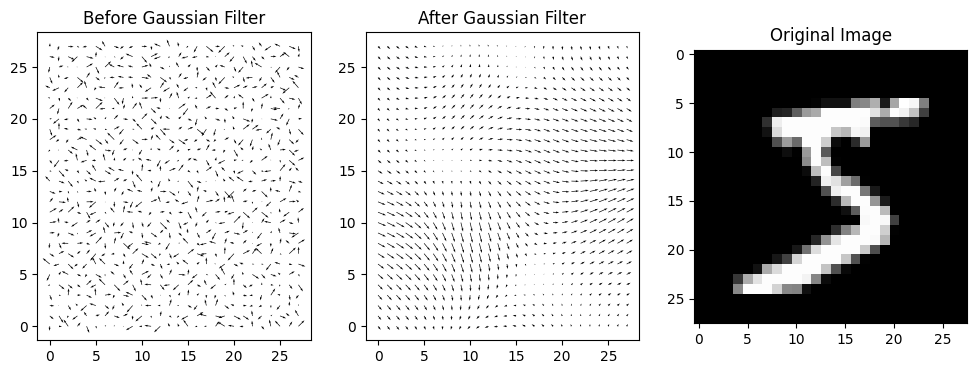

In [6]:
x, y = np.mgrid[0:28, 0:28]
    
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.quiver(x, y, dx1, dy1)
plt.title('Before Gaussian Filter')
plt.subplot(132)
plt.quiver(x, y, dx2, dy2)
plt.title('After Gaussian Filter')
# Demonstrate elastic transform on MNIST image
img = x_train[0]
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

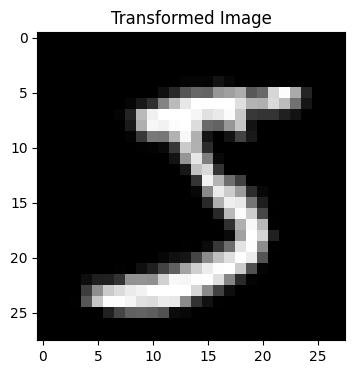

In [7]:
transformed_img = batch_elastic_transform(
    img.reshape(1, -1), 
    sigma=4, 
    alpha=20, 
    height=28, 
    width=28
)
    
plt.figure(figsize=(4, 4))
plt.imshow(transformed_img.reshape(28, 28), cmap='gray')
plt.title('Transformed Image')
plt.show()

In [8]:
def transform_dataset(x_train, batch_size=1000, sigma=4, alpha=20):
    """
    Transform entire dataset in batches to avoid memory issues
    """
    height, width = x_train.shape[1:]
    n_samples = x_train.shape[0]
    
    # Initialize array for transformed images
    transformed_images = np.zeros((n_samples, height * width))
    
    # Process in batches
    for i in tqdm(range(0, n_samples, batch_size)):
        batch_end = min(i + batch_size, n_samples)
        batch = x_train[i:batch_end]
        
        # Reshape batch to 2D array (n_samples, pixels)
        batch_flat = batch.reshape(batch_end - i, -1)
        
        # Apply transformation
        transformed = batch_elastic_transform(
            batch_flat, 
            sigma=sigma, 
            alpha=alpha,
            height=height,
            width=width
        )
        
        transformed_images[i:batch_end] = transformed
    
    return transformed_images

In [9]:
transformed_train = transform_dataset(x_train)

100%|██████████| 60/60 [00:09<00:00,  6.13it/s]


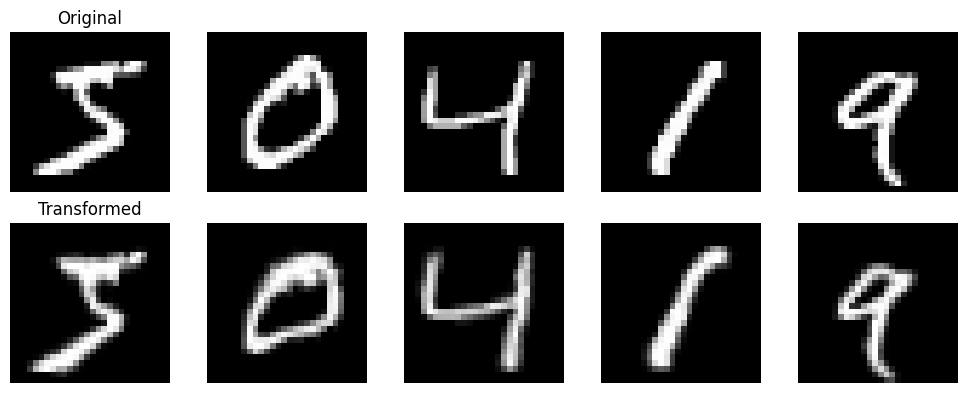

In [10]:
def plot_comparison(original, transformed, num_images=5):
    plt.figure(figsize=(2*num_images, 4))
    
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
            
        # Transformed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(transformed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Transformed')
    
    plt.tight_layout()
    plt.show()

# Plot some examples
plot_comparison(x_train, transformed_train)

In [11]:
class AttentionAutoencoder(tf.keras.Model):
    def __init__(self, input_shape, n_classes, **kwargs):
        super(AttentionAutoencoder, self).__init__(**kwargs)
        self.input_shape_ = input_shape
        self.n_classes = n_classes
        
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(10, 3, strides=1, padding='same', activation='relu'),
            tf.keras.layers.Flatten()
        ])

        self.downsize = tf.keras.layers.Dense(15)
        # Attention layers
        self.attention = tf.keras.layers.Attention()
        self.query_dense = tf.keras.layers.Dense(15)
        self.value_dense = tf.keras.layers.Dense(15)
        
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(15,)),
            tf.keras.layers.Dense(4*4*10),
            tf.keras.layers.Reshape((4, 4, 10)),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 4x4x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),  # 8x8x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 14x14x32
            tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid') # 28x28x1
        ])
        
        # Classification layer
        self.classifier = tf.keras.layers.Dense(n_classes)

        print(self.encoder.summary())
        print(self.decoder.summary())


    def call(self, inputs):
        # Ensure input shape is correct
        if len(inputs.shape) == 2:
            inputs = tf.reshape(inputs, [-1, 28, 28, 1])
            
        # Encode
        features = self.downsize(self.encoder(inputs))
        query = self.query_dense(features)
        value = self.value_dense(features)

        query = tf.expand_dims(query, axis=1)
        value = tf.expand_dims(value, axis=1)

        # Apply attention
        attention_output = self.attention([query, value])
        attention_weights = tf.matmul(query, tf.transpose(value, [0, 2, 1]))
        attention_weights = tf.nn.softmax(attention_weights)
        
        attended_features = tf.squeeze(attention_output, axis=1)
        
        # Get logits
        logits = self.classifier(attended_features)
        
        # Decode
        decoded = self.decoder(features)
        
        return logits, decoded, features, attended_features, attention_weights

    def get_config(self):
        config = super(AttentionAutoencoder, self).get_config()
        config.update({
            "input_shape": self.input_shape_,
            "n_classes": self.n_classes,
        })
        return config

    @classmethod
    def from_config(cls, config):
        input_shape = config.pop("input_shape", (28, 28, 1))  
        n_classes = config.pop("n_classes", 10)           
        return cls(input_shape=input_shape, n_classes=n_classes, **config)

In [12]:
def train_step(model, optimizer, x, y, lambda_params):
    with tf.GradientTape() as tape:
        # Forward pass
        x = tf.reshape(x, [-1, 28, 28, 1])
        logits, decoded, features, attended_features, attention_weights = model(x)

        # Calculate losses
        y = tf.reshape(y, [-1, 10])
        classification_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
        )
        x_flat = tf.reshape(x, [-1, 784])
        decoded_flat = tf.reshape(decoded, [-1, 784])
        
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x_flat, decoded_flat)
        )
        
        # Attention diversity loss - encourages diverse attention patterns
        kl_loss = tf.keras.losses.KLDivergence()
        uniform_dist = tf.ones_like(attention_weights) / tf.cast(tf.shape(attention_weights)[1], tf.float32)
        attention_loss = kl_loss(uniform_dist, attention_weights)
        
        # Total loss
        total_loss = (lambda_params['class'] * classification_loss + 
                     lambda_params['ae'] * reconstruction_loss +
                     lambda_params['attention'] * attention_loss)
    
    # Backpropagation
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return {
        'classification': classification_loss,
        'reconstruction': reconstruction_loss,
        'attention': attention_loss,
        'total': total_loss
    }

In [13]:
def visualize_reconstructions(model, dataset):
    # Get multiple batches of images and select diverse samples
    sample_images = []
    for x_batch, _ in dataset.take(5):
        # Select 2 random images from each batch
        indices = tf.random.shuffle(tf.range(x_batch.shape[0]))[:2]
        sample_images.extend(tf.gather(x_batch, indices))
        if len(sample_images) >= 10:
            break
    
    sample_images = tf.stack(sample_images[:10])
    sample_images = tf.reshape(sample_images, [-1, 28, 28, 1])  # Ensure 4D shape
    
    # Reconstruct images
    _, reconstructed, _, _, _ = model(sample_images)
    
    # Plot results
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    plt.suptitle('Original Images (top) vs Reconstructed Images (bottom)', y=1.05)
    
    for i in range(10):
        # Ensure proper shape for visualization
        orig_img = tf.squeeze(sample_images[i]).numpy()
        recon_img = tf.squeeze(reconstructed[i]).numpy()
        
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
def train_model(model, train_dataset, valid_dataset, test_dataset, epochs=1500, 
                learning_rate=0.002, batch_size=250, log_dir="logs"):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    lambda_params = {'class': 20, 'ae': 1, 'attention': 0.1}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} ")
        
        # Training loop
        for x_batch, y_batch in train_dataset:
            # Apply elastic transform
            x_batch = tf.reshape(x_batch, [-1, 28, 28, 1])
            x_flat = tf.reshape(x_batch, [-1, 784])
            x_batch_elastic = batch_elastic_transform(x_flat, sigma=4, alpha=20, 
                                                    height=28, width=28)
            losses = train_step(model, optimizer, x_batch_elastic, y_batch, lambda_params)
            
        # Validation
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in valid_dataset:
            logits, _, _, _, _ = model(x_val)
            val_accuracy.update_state(y_val, logits)
            
        print(f"Validation accuracy: {val_accuracy.result():.4f}, Loss: {losses}\n")

In [15]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [16]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(250)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test[:5000], y_test[:5000])).batch(250)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test[5000:], y_test[5000:])).batch(250)

In [17]:
# Create and train model
model = AttentionAutoencoder(input_shape=(28, 28, 1), n_classes=10)

/u/prebello/dls/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 160)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 24,257 (94.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
train_model(model, train_dataset, valid_dataset, test_dataset)

Epoch 1/1500 


/u/prebello/dls/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (250, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
I0000 00:00:1733620006.649777 2284335 cuda_dnn.cc:529] Loaded cuDNN version 90400
2024-12-07 20:07:21.797016: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 20:07:22.113412: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9494, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.21143008768558502>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.20915615558624268>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=4.437757968902588>}

Epoch 2/1500 


2024-12-07 20:07:55.064184: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9630, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.16316907107830048>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.19456616044044495>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=3.4579477310180664>}

Epoch 3/1500 
Validation accuracy: 0.9744, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.19960296154022217>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.18609388172626495>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=4.178153038024902>}

Epoch 4/1500 


2024-12-07 20:09:01.684367: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9746, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.1404392123222351>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1827733963727951>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.9915575981140137>}

Epoch 5/1500 
Validation accuracy: 0.9810, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.118929922580719>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.183968648314476>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.5625669956207275>}

Epoch 6/1500 
Validation accuracy: 0.9810, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.11802062392234802>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1825634092092514>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=fl

2024-12-07 20:11:15.038208: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9828, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.13108722865581512>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.18268096446990967>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.8044257164001465>}

Epoch 9/1500 
Validation accuracy: 0.9836, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09326973557472229>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17745298147201538>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.0428476333618164>}

Epoch 10/1500 
Validation accuracy: 0.9856, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.11529780179262161>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17768925428390503>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), 

2024-12-07 20:15:41.657560: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9868, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07431590557098389>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17553044855594635>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.661848545074463>}

Epoch 17/1500 
Validation accuracy: 0.9862, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09839074313640594>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17275547981262207>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.1405704021453857>}

Epoch 18/1500 
Validation accuracy: 0.9856, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10918983817100525>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17355582118034363>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), 

2024-12-07 20:24:33.175817: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9914, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08710871636867523>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17406989634037018>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.9162442684173584>}

Epoch 33/1500 
Validation accuracy: 0.9870, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.0710301622748375>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17129793763160706>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.591901183128357>}

Epoch 34/1500 
Validation accuracy: 0.9882, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07297717779874802>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17039431631565094>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), d

2024-12-07 20:42:12.377965: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9886, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08070772886276245>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1687857210636139>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.7829402685165405>}

Epoch 65/1500 
Validation accuracy: 0.9906, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.057919230312108994>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16404277086257935>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.3224272727966309>}

Epoch 66/1500 
Validation accuracy: 0.9882, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07583405822515488>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16911087930202484>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(),

2024-12-07 21:18:15.357404: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9898, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08908432722091675>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16056488454341888>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.942251443862915>}

Epoch 129/1500 
Validation accuracy: 0.9910, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07799661159515381>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16069161891937256>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.7206238508224487>}

Epoch 130/1500 
Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.03368454799056053>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16306374967098236>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=()

2024-12-07 22:28:30.077118: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9918, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.026811156421899796>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15915131568908691>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6953744292259216>}

Epoch 257/1500 
Validation accuracy: 0.9926, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.030921045690774918>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16061852872371674>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.7790394425392151>}

Epoch 258/1500 
Validation accuracy: 0.9928, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.029648425057530403>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15924052894115448>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shap

2024-12-08 01:14:51.537843: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9900, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.02302577905356884>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15859484672546387>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6191104650497437>}

Epoch 513/1500 
Validation accuracy: 0.9920, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.012579294852912426>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1614653319120407>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.4130512475967407>}

Epoch 514/1500 
Validation accuracy: 0.9896, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.027244141325354576>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15965530276298523>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=

2024-12-08 05:54:52.602903: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9912, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.04107028245925903>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16002796590328217>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.981433629989624>}

Epoch 1025/1500 
Validation accuracy: 0.9918, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05118860676884651>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16210252046585083>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.1858747005462646>}

Epoch 1026/1500 
Validation accuracy: 0.9906, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.026119934394955635>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1623816043138504>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'total': <tf.Tensor: shape=

In [20]:
model.save("mnist_attention_model.keras")

In [22]:
model_save = tf.keras.models.load_model("mnist_attention_model.keras", custom_objects={"AttentionAutoencoder": AttentionAutoencoder})

/u/prebello/dls/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 160)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 24,257 (94.75 KB)

 Non-trainable params: 0 (0.00 B)

None


/u/prebello/dls/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (250, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


/u/prebello/dls/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (10, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


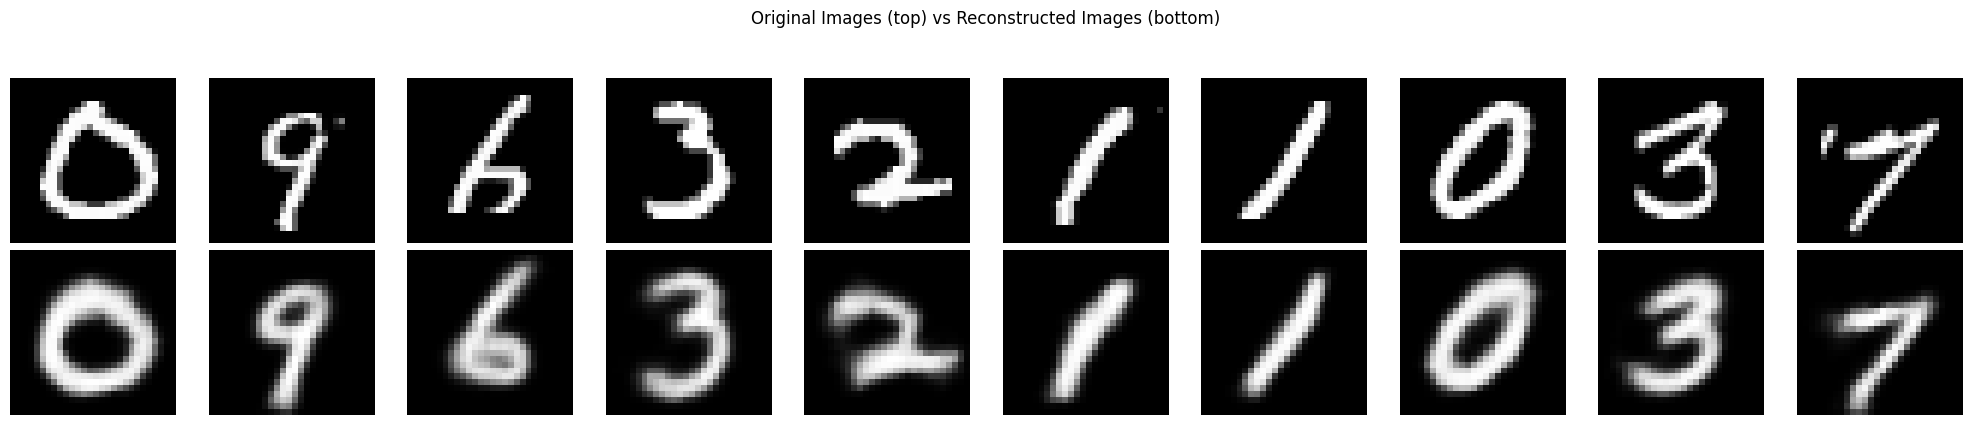

In [23]:
visualize_reconstructions(model, train_dataset)

In [24]:
def visualize_image_class_weights(model, dataset):
    # Get one sample image from each class
    images_by_class = [[] for _ in range(10)]
    for x_batch, y_batch in dataset:
        y_labels = tf.argmax(y_batch, axis=1)
        for img, label in zip(x_batch, y_labels):
            images_by_class[label.numpy()].append(img)
        if all(len(c) > 0 for c in images_by_class):
            break
    
    # Select first image from each class
    sample_images = [class_images[0] for class_images in images_by_class]
    sample_images = tf.stack(sample_images)
    
    # Get logits through the model
    logits, _, _, _, _ = model(sample_images)
    
    # Create figure with proper sizing
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 1, height_ratios=[4, 1])
    
    # Plot weight matrix
    ax_weights = fig.add_subplot(gs[0])
    im = ax_weights.imshow(logits.numpy(), cmap='RdBu_r')
    plt.colorbar(im)
    
    # Add weight values in cells
    for i in range(logits.shape[0]):
        for j in range(logits.shape[1]):
            text_color = 'white' if abs(logits[i, j]) > 10 else 'black'
            ax_weights.text(j, i, f'{logits[i, j]:.2f}',
                          ha='center', va='center', color=text_color)
    
    # Plot sample digits on right side
    ax_images = fig.add_subplot(gs[1])
    for i in range(10):
        ax_images.imshow(sample_images[i], 
                        extent=[i-0.5, i+0.5, 0, 1],
                        cmap='gray')
    
    # Configure axes
    ax_weights.set_xticks(range(10))
    ax_weights.set_xticklabels(range(10))
    ax_weights.set_ylabel('Input Images')
    ax_weights.set_xlabel('Digit Classes')
    ax_images.set_xticks([])
    ax_images.set_yticks([])
    
    plt.suptitle('Image-to-Class Weight Matrix')
    plt.tight_layout()
    plt.show()

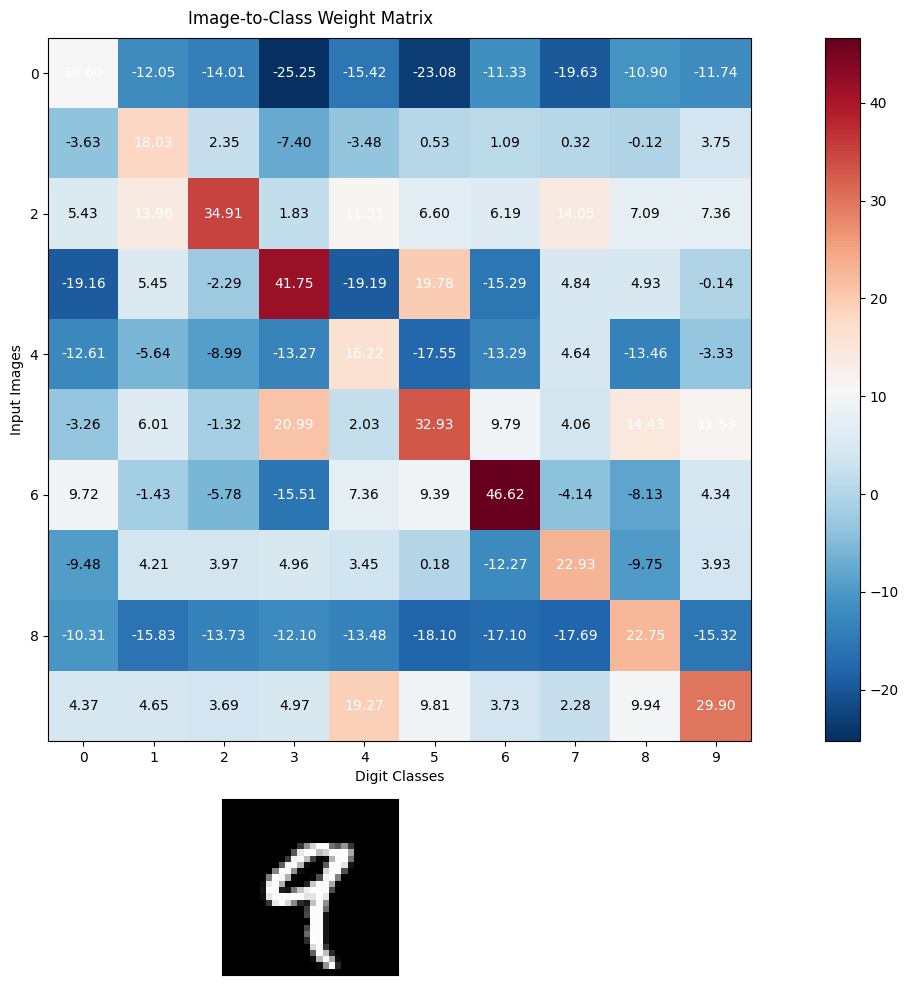

In [25]:
visualize_image_class_weights(model, train_dataset)

In [26]:
val_accuracy = tf.keras.metrics.CategoricalAccuracy()
for x_tst, y_tst in test_dataset:
    logits, decoded_images, features, attended_features, attention_weights = model(x_tst)
    val_accuracy.update_state(y_tst, logits)
    
print(f"Test accuracy: {val_accuracy.result():.4f}\n")

/u/prebello/dls/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (250, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Test accuracy: 0.9944



In [44]:
batch_size = 10
inputs = x_test[:batch_size]  

logits, decoded_images, features, attended_features, attention_weights = model(inputs)
activations = attended_features.numpy() 
reconstructed_images = decoded_images.numpy()
attention_weights = attention_weights.numpy()

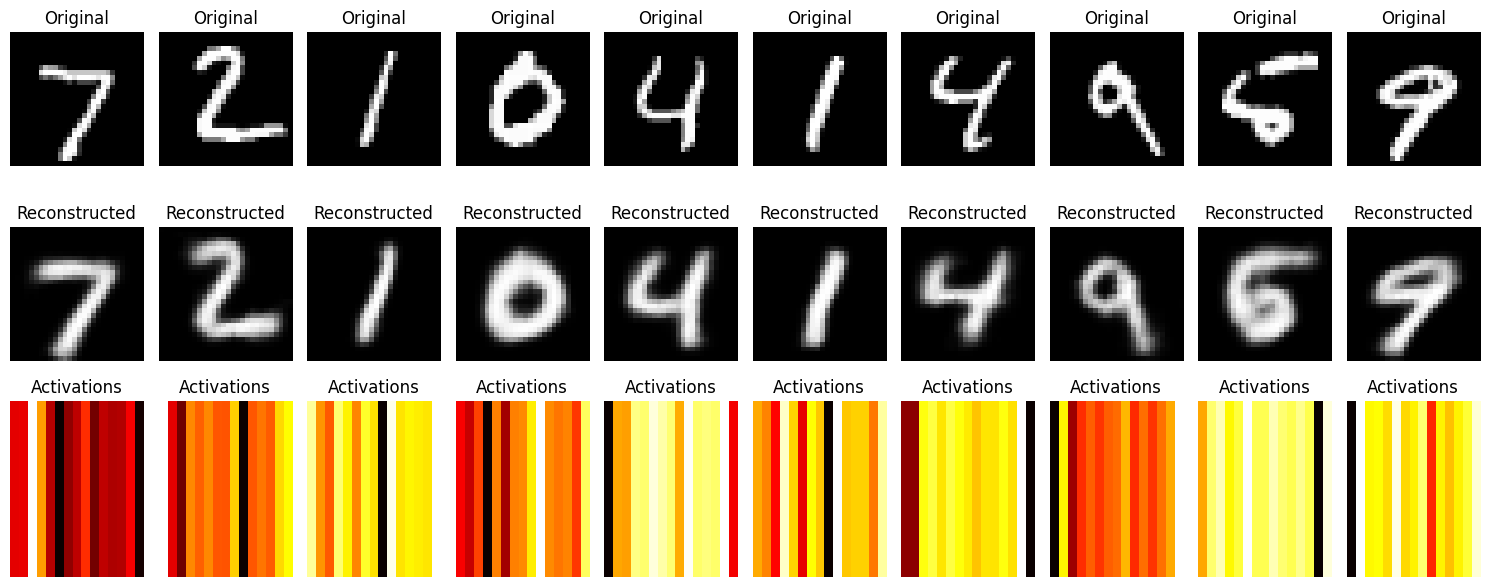

In [41]:
# Plot original images, reconstructed images, and prototypes
fig, axes = plt.subplots(3, batch_size, figsize=(15, 6))

for i in range(batch_size):
    # Original image
    axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed image
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

    # Prototype as heatmap
    activation = activations[i]
    axes[2, i].imshow(activation.reshape(1, -1), cmap='hot', aspect='auto')  # Reshape for heatmap
    axes[2, i].axis('off')
    axes[2, i].set_title("Activations")

plt.tight_layout()
plt.show()

In [46]:
# Check the shape of attention_weights
print("Attention Weights Shape:", attention_weights.shape)

Attention Weights Shape: (10, 1, 1)


In [21]:
import numpy as np

def compute_attention_rollout(attention_weights, image_size=28):
    print("Attention weights shape:", attention_weights.shape)
    attention = tf.squeeze(attention_weights)  # Shape becomes (10,)
    attention = tf.reshape(attention, (-1, 1)) @ tf.reshape(attention, (1, -1))
    attention = attention + tf.eye(10)
    attention = attention / tf.reduce_sum(attention, axis=-1, keepdims=True)
    rollout = tf.eye(10)
    rollout = tf.matmul(rollout, attention)
    rollout = (rollout - tf.reduce_min(rollout)) / (tf.reduce_max(rollout) - tf.reduce_min(rollout))
    rollout = tf.reshape(rollout, (10, 10, 1))
    rollout = tf.image.resize(rollout, (image_size, image_size), method='bicubic')
    return rollout

def process_attention_map(rollout, image_size=28):
    attention_map = tf.reshape(rollout, [-1, int(tf.sqrt(float(rollout.shape[-1]))), 
                                       int(tf.sqrt(float(rollout.shape[-1])))])
    attention_map = tf.image.resize(attention_map, [image_size, image_size])
    attention_map = tf.image.resize(attention_map, [image_size, image_size], 
                                  method='gaussian')
    return attention_map

# Visualize attention rollout
def create_attention_visualization(attention_map, original_image=None):
    attention_map = tf.cast(attention_map, tf.float32)
    
    # Create heatmap
    heatmap = tf.image.resize(attention_map, [28, 28])
    heatmap = tf.image.grayscale_to_rgb(heatmap)
    
    if original_image is not None:
        original_image = tf.cast(original_image, tf.float32)
        if len(original_image.shape) == 2:
            original_image = tf.stack([original_image] * 3, axis=-1)
            
        original_image = original_image / tf.reduce_max(original_image)
        heatmap = heatmap / tf.reduce_max(heatmap)
        
        alpha = 0.6
        overlay = alpha * original_image + (1 - alpha) * heatmap
        return overlay
    return heatmap


In [19]:
from tensorflow.keras.models import load_model

model = load_model('mnist_attention_model.keras', custom_objects={'AttentionAutoencoder': AttentionAutoencoder})

/u/prebello/dls/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 160)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 24,257 (94.75 KB)

 Non-trainable params: 0 (0.00 B)

None


/u/prebello/dls/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (250, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [29]:
test_image = x_test[0]
test_image = tf.expand_dims(test_image, 0)
logits, decoded_images, features, attended_features, attention_weights = model(test_image)

# Get attention rollout
rollout = compute_attention_rollout(attention_weights)

# Process attention map
attention_map = process_attention_map(rollout)

heatmap = create_attention_visualization(attention_map, x_test[0])

Attention weights shape: (1, 1, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.042531848..0.99764705].


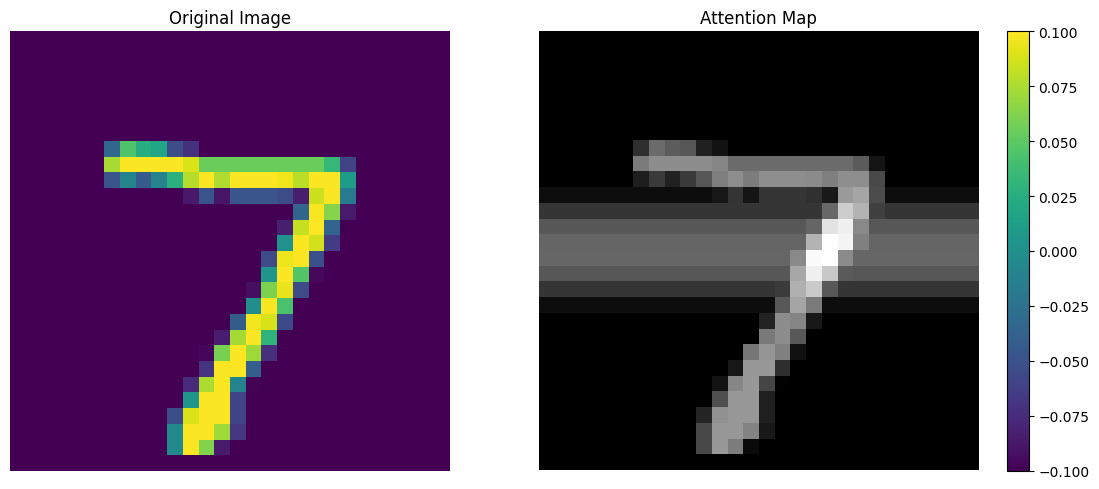

In [30]:
def plot_attention_visualization(original_image, attention_map):
    plt.figure(figsize=(12, 5))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='viridis')
    plt.axis('off')
    
    # Plot attention map
    plt.subplot(1, 2, 2)
    plt.title('Attention Map')
    im = plt.imshow(heatmap, cmap='viridis', vmin=-0.100, vmax=0.100)
    plt.colorbar(im, orientation='vertical')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_attention_visualization(tf.squeeze(test_image), tf.squeeze(heatmap))

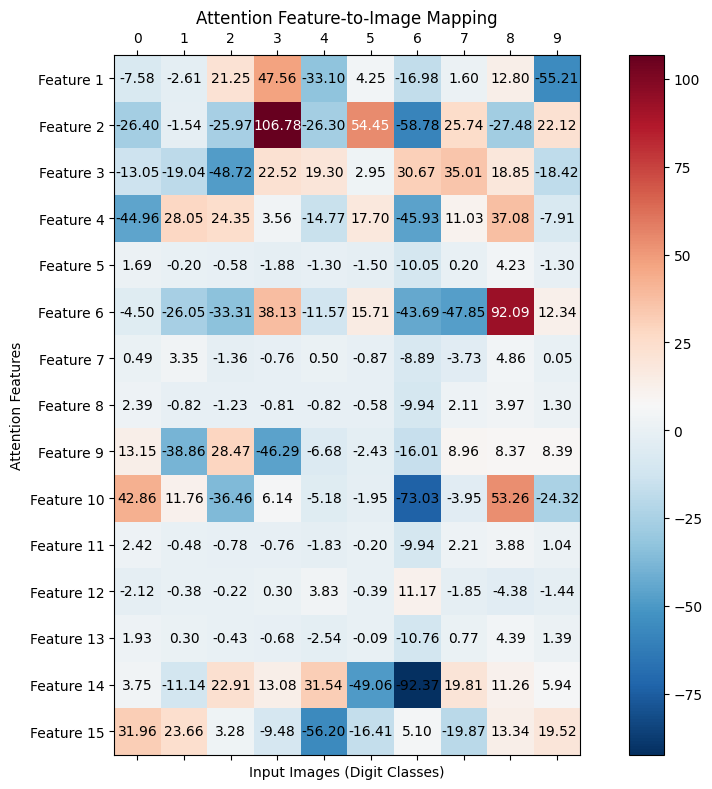

In [32]:
def visualize_image_attention_features_flipped(model, dataset):
    # Get one sample image from each class
    images_by_class = [[] for _ in range(10)]
    for x_batch, y_batch in dataset:
        y_labels = tf.argmax(y_batch, axis=1)
        for img, label in zip(x_batch, y_labels):
            images_by_class[label.numpy()].append(img)
        if all(len(c) > 0 for c in images_by_class):
            break
    
    # Select first image from each class
    sample_images = [class_images[0] for class_images in images_by_class]
    sample_images = tf.stack(sample_images)
    
    # Get features through the model
    logits, decoded_images, features, attention_features, attention_weights = model(sample_images)
    
    # Convert attention features to numpy and transpose for flipped axes
    attention_features = attention_features.numpy().T  # Transpose matrix
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(attention_features, cmap='RdBu_r')
    fig.colorbar(cax)

    # Annotate cells with feature values
    for i in range(attention_features.shape[0]):
        for j in range(attention_features.shape[1]):
            text_color = 'white' if attention_features[i, j] > 0.5 * attention_features.max() else 'black'
            ax.text(j, i, f'{attention_features[i, j]:.2f}', ha='center', va='center', color=text_color)
    
    # Configure axes
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_yticks(range(attention_features.shape[0]))
    ax.set_yticklabels([f"Feature {i+1}" for i in range(attention_features.shape[0])])
    ax.set_xlabel('Input Images (Digit Classes)')
    ax.set_ylabel('Attention Features')
    plt.title('Attention Feature-to-Image Mapping')
    plt.tight_layout()
    plt.show()

# Assuming `model` is an instance of AttentionAutoencoder and `dataset` is a batched tf.data.Dataset
visualize_image_attention_features_flipped(model, train_dataset)


In [33]:
def evaluate_classification_accuracy(model, test_dataset):
    """
    Evaluate classification accuracy of the model
    Args:
    - model: Trained AttentionAutoencoder model
    - test_dataset: Test dataset
    Returns:
    - Accuracy
    - Confusion Matrix
    """
    # Collect true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset
    for batch in test_dataset:
        # Unpack images and labels
        images, labels = batch

        # Ensure images are in the right shape
        if len(images.shape) == 3:
            images = tf.expand_dims(images, axis=-1)

        # Get logits from the model
        logits, *_ = model(images)

        # Get predicted classes
        predictions = tf.argmax(logits, axis=1)

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = tf.argmax(labels, axis=1)

        # Extend the lists
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.numpy())

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate accuracy
    accuracy = np.mean(true_labels == predicted_labels)

    # Compute confusion matrix
    confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predicted_labels,
        num_classes=10  # MNIST has 10 classes
    ).numpy()

    return accuracy, confusion_matrix, true_labels, predicted_labels

/u/prebello/dls/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (250, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
2024-12-15 23:41:53.788838: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Accuracy: 99.44%


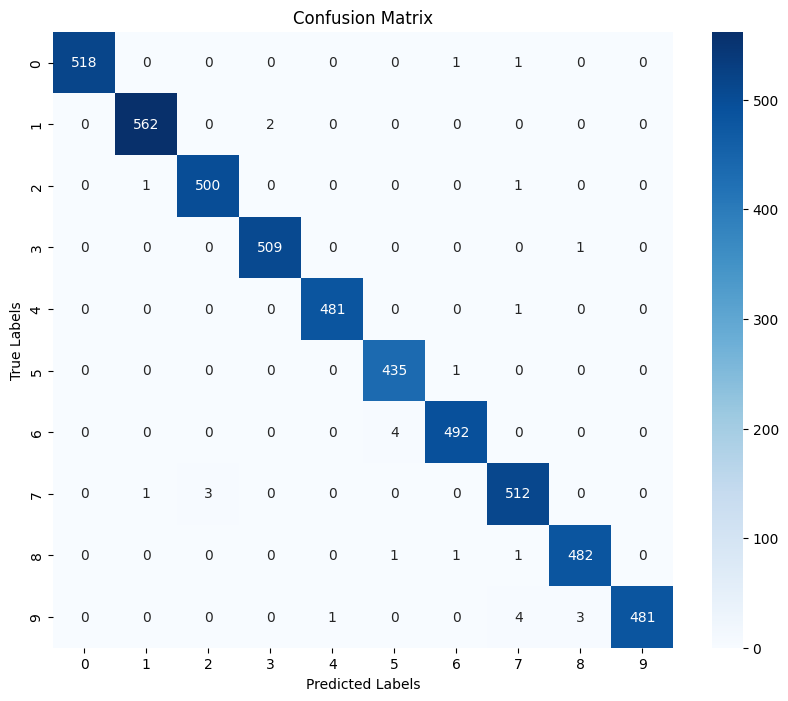

In [35]:
import seaborn as sns
# Visualize confusion matrix
accuracy, conf_matrix, true_labels, predicted_labels = evaluate_classification_accuracy(model, test_dataset)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()